# A notebook to generate all the plots for my report

In [1]:
import os, torch 
import pandas as pd
import numpy as np
from src.data_worker import get_data
from src import evaluate
from src.weigh_prune import model_weight_distribution,weigh,get_loss,gen_file_lines
from other.plots import benign_compressed_models
from src.attack import ryax_attacker,Carlini_Wagner


import altair as alt
from matplotlib import pyplot as plt

CIFAR10_LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
CIFAR100_LABELS = sorted(['apples','aquarium','baby','bear','beaver','bed','bee','beetle','bicycle','bottles',
                   'bowls','boy','bridge','bus','butterfly','camel','cans','castle','caterpillar','cattle',
                   'chair','chimpanzee','clock','cloud','cockroach','computer keyboard''couch','crab','crocodile',
                   'cups','dinosaur','dolphin','fish','flatfish','forest','fox','girl','hamster',
                   'house','kangaroo','lamp','lawn-mower','leopard','lion','lizard','lobster','man','maple',
                   'motorcycle','mountain','mouse','mushrooms','oak','oranges','orchids','otter','palm',
                   'pears','pickup','pine','plain','plates','poppies','porcupine','possum','rabbit',
                   'raccoon','ray','road','rocket','roses','sea','seal','shark','shrew','skunk','skyscraper',
                   'snail','snake','spider','squirrel','streetcar','sunflowers','sweet peppers','table',
                   'tank','telephone','television','tiger','tractor','trout','train','truck','tulips',
                      'turtle','wardrobe','whale','willow','wolf','woman','worm'])
CIFAR100_LABELS.sort()
%load_ext autoreload
%autoreload 2

class Mydata:
    @classmethod
    def load_models(cls,d = 'models/cifar10_models/'):
        from src.resnet_model.resnet_dense import ResNet34 as ResNet
        from src.effnet_models.mobilenetv2 import MobileNetV2 as MobNet
        from src.effnet_models.mobilenetv2_cifar100 import MobileNetV2 as Mob100
        mods = {}
        cls = 100 if '100' in d else 10
        for f in os.listdir(d):
            if f[-4:]=='.pth':
                if 'resnet' in f:
                    mods[f[:-4]] = ResNet(classes=cls)
                elif cls==10:
                    mods[f[:-4]] = MobNet(alpha=1.0)
                else:
                    mods[f[:-4]] = Mob100()
                    
                mods[f[:-4]].load_state_dict(torch.load(d+f), strict = False)
        return mods
                  
    @classmethod
    def load_test_data(cls,batchsz = 1):
        return get_data(test = True,
                     batch_size = batchsz,
                     dataset = 'cifar10',
                     download = False),\
                get_data(test = True,
                     batch_size = batchsz,
                     dataset = 'cifar100',
                     download = False)

def get_CW_atk(m,eps,steps):
    return Carlini_Wagner(model=m,epsilon=eps,steps=steps).get_attack()

pgd_attacker = ryax_attacker(epsilon=8)

In [82]:
def tensor2image(img):
        return np.transpose(img.numpy(), (1, 2, 0))

def show_panel(data,dataset='cifar10', savefig = False):
    fig = plt.figure(figsize = (16,16))
    ax = []
    for i in range(len(data)):
        if len(data[i])==2:
            tns,label = data[i]
            title = CIFAR100_LABELS[int(label)] if '100' in dataset else CIFAR10_LABELS[int(label)]
        else:
            tns,label,title = data[i]
        image = tensor2image(tns[0])
        ax.append(fig.add_subplot(1,len(data), i+1))
        ax[-1].set_title(title, fontsize=22) 
        ax[-1].set_yticklabels([])
        ax[-1].set_xticklabels([])
        ax[-1].axis('off')
        plt.imshow(image)
    if savefig:
        plt.savefig(savefig+'.png')

def perturbed_display(mod,tns,lab,attacker,ep_start = 0.5,coeff = 2,savefig=False, dataset='cifar10'):
    attacker.epsilon = ep_start
    labs = CIFAR100_LABELS if '100' in dataset else CIFAR10_LABELS
    disp = [[tns,lab]]
    for i in range(8):
        atk = attacker.get_attack()
        tns_adv, _ = atk(mod,tns,lab)
        pred = list(mod(tns_adv).data[0])
        pred = pred.index(max(pred))
        if i==9000000:
            tit = "{}\n\u03B5 = {}".format(labs[int(pred)],round(attacker.epsilon/255,3))
        else:
            tit = "\u03B5 = {}".format(round(attacker.epsilon/255,3))
        disp.append([tns_adv,pred,tit])
        if type(coeff)==list:
            attacker.epsilon = coeff[i+1] if i<7 else coeff[i]
        else:
            attacker.epsilon *= coeff
    show_panel(disp)

def ensure_len(x,y):
    flag = 1 if len(x)<len(y) else 0
    while len(x)!=len(y):
        if flag==1:
            x.append(None)
        else:
            y.append(None)
    return x,y
        
def hist_panel(*args,suptit =' ',subtit = [' ']*10,savefig=False):
    wd = lambda x: model_weight_distribution(x)
    fig, ax = plt.subplots(1, len(args), figsize=(16,6), sharex=True, sharey=False)
    colors = ['r','b','g','k','w']
    params = dict(alpha=0.3, bins=300,density=True,range=[-.25,.25])
    for i in range(len(args)):
        if len(args[i])>1:
            data = []
            legends = []
            for item in args[i]:
                if type(item)==str:
                    legends.append(item)
                else:
                    data.append(wd(item))
            data,legends = ensure_len(data,legends)
            for k in range(len(data)):
                lab = legends[k]
                if len(args)==1:
                    ax.hist(data[k], **params, label=lab, color=colors[k])
                else:
                    ax[i].hist(data[k], **params, label=lab, color=colors[k])           
        else:
            if len(args)==1:
                ax.hist(args[i], **params, label=str(i), color=colors[0])
            else:
                ax[i].hist(args[i], **params, label=str(i), color=colors[0])
        if len(args)==1:
            ax.set_title(subtit[i])
            ax.legend()
            ax.set_yticklabels([])
        else:
            ax[i].set_title(subtit[i])
            ax[i].legend()
            ax[i].set_yticklabels([])
    plt.suptitle(suptit, y=1.05, size=16)
    if savefig:
        plt.savefig('HISTO.png')


In [3]:
# Load both cifar datasets into iterators (If batches are needed, load again)
cifar10,cifar100 = Mydata.load_test_data(1)
cifar10, cifar100 = iter(cifar10), iter(cifar100)

# Load all models
c10mods = Mydata.load_models('models/cifar10_models/')
c100mods = Mydata.load_models('models/cifar100_models/')

def list_dict(d):
    for k,v in sorted(d.items()):
        print(k)

### A cell just to look at cifar100 data

In [4]:
c100tns,c100lab = next(cifar100)

def show8():
    pic = []
    for i in range(8):
        tens, label = next(cifar100)
        pic.append([tens,label])
    show_panel(pic,dataset='cifar100')

# for i in range(8):
#     show8()

### Benign & compessed CNNs: accuracy report

In [5]:
benign_compressed_models_results = benign_compressed_models()
def acc_vs_compression(df):
    return alt.Chart(df, width = 500).mark_line(point=True).encode(
                        x=alt.X('compression ratio:O',
                                sort=alt.EncodingSortField('compression ratio', order='descending'),
                               axis = alt.Axis(title=None)),
                        y=alt.Y('accuracy:Q',axis=alt.Axis(title=None)),
                        color=alt.Color('test:N',
                        legend=alt.Legend(title=None,labelFontSize=13,orient='top-right'),
                                       scale=alt.Scale(
                                        domain=['Mobilenet adv', 'Mobilenet benign','Resnet adv','Resnet benign'],
                                        range=['#a1d99b', '#31a354','#fdae6b','#e6550d'])))

acc_vs_compression(benign_compressed_models_results)

alt.Chart(...)

In [6]:
list_dict(c10mods)
print('---------------------')
list_dict(c100mods)

mobilenet_dense
mobilenet_mymethod_pgd26
mobilenet_mymethod_pgd26_1pruned
mobilenet_mymethod_pgd26_5pruned
mobilenet_mymethod_pgd8
mobilenet_mymethod_pgd8_1pruned
mobilenet_mymethod_pgd8_5pruned
mobilenet_pgd_dense
resnet_1pruned_old
resnet_dense1
resnet_mymethod_pgd26
resnet_mymethod_pgd26_1pruned_constloss
resnet_mymethod_pgd26_5pruned
resnet_mymethod_pgd26_5pruned_constloss
resnet_mymethod_pgd8_1pruned
resnet_mymethod_pgd8_5pruned
resnet_mymethod_pgd8_adv
resnet_pgd
---------------------
mobilenet_dense
mobilenet_mymethod_pgd8
resnet_01pruned
resnet_1pruned
resnet_dense
resnet_mymethod_pgd26_1pruned
resnet_mymethod_pgd26_5pruned
resnet_mymethod_pgd26_constantloss
resnet_mymethod_pgd8_1pruned
resnet_mymethod_pgd8_5pruned
resnet_mymethod_pgd8_adv_constantloss
resnet_pgd_dense


## Weight Distributions

## The next 4 cells are to produce the histograms for my report. The ones with compressed models require changing the panel function kwargs to log=True and increasing the range to [-1,1]. The dense ones use log=False and range [-.1,.1] +- 0.2



In [7]:
# hist_panel([c10mods['resnet_dense1'],'- Benign\nAcc: {}\nAdv acc: {}'.format(0.94,0.02),
#             c10mods['resnet_mymethod_pgd26'],'- Adv\nAcc: {}\nAdv acc: {}'.format(0.76,0.67)],
#            [c100mods['resnet_dense'],'- Benign\nAcc: {}\nAdv acc: {}'.format(0.72,0.02),
#             c100mods['resnet_mymethod_pgd26_constantloss'],'- Adv\nAcc: {}\nAdv acc: {}'.format(0.52,0.35)],
#            subtit = ['',''],
#              suptit = '',savefig=True)

In [8]:
# hist_panel([c10mods['resnet_mymethod_pgd8_adv'],'Dense\nAcc: {}\nAdv acc: {}'.format(0.89,0.62),
#             c10mods['mobilenet_dense'],'50% Size\nAcc: {}\nAdv acc: {}'.format(0.88,0.61),
#             c10mods['resnet_mymethod_pgd8_1pruned'],'10% Size\nAcc: {}\nAdv acc: {}'.format(0.88,0.61)],
#             subtit = ['','',''],
#             suptit='',savefig=True)

In [9]:
# hist_panel([c10mods['mobilenet_dense'],'- Benign\nAcc: {}\nAdv acc: {}'.format(0.93,0.004),
#             c10mods['mobilenet_mymethod_pgd26'],'- Adv\nAcc: {}\nAdv acc: {}'.format(0.87,0.57)],
#            [c100mods['mobilenet_dense'],'- Benign\nAcc: {}\nAdv acc: {}'.format(0.66,0.004),
#             c100mods['mobilenet_mymethod_pgd8'],'- Adv\nAcc: {}\nAdv acc: {}'.format(0.58,0.22)],
#            subtit = ['',''],
#              suptit = '',savefig=True)



In [10]:
# hist_panel([c10mods['mobilenet_mymethod_pgd8'],'Dense\nAcc: {}\nAdv acc: {}'.format(0.87,0.573),
#             c10mods['mobilenet_mymethod_pgd8_5pruned'],'50% Size\nAcc: {}\nAdv acc: {}'.format(0.85,0.570),
#             c10mods['mobilenet_mymethod_pgd8_1pruned'],'10% Size\nAcc: {}\nAdv acc: {}'.format(0.85,0.570)],
#             subtit = ['','',''],
#             suptit='',savefig=True)

## How much is lost on the adversarial set as weights are sparser and sparser?

In [11]:
# elbow_test = {}
# elbow_test['resnet_dense1']={0.0: 0.9187, 0.02: 0.1315, 0.04: 0.034}
# # Total elapsed time = 113.8132758140564s
# elbow_test['resnet_pgd']={0.0: 0.8815, 0.02: 0.6804, 0.04: 0.5583, 0.06: 0.461, 0.08: 0.3982, 0.1: 0.3414, 0.12: 0.303, 0.14: 0.2679, 0.16: 0.2441, 0.18: 0.2212, 0.2: 0.2036, 0.22: 0.1898, 0.24: 0.1694, 0.26: 0.1596, 0.28: 0.1496, 0.3: 0.1363, 0.32: 0.1264, 0.34: 0.1217, 0.36: 0.1128, 0.38: 0.1111, 0.4: 0.1003}
# # Total elapsed time = 1094.5425481796265s
# elbow_test['resnet_pgd_75adal0proj']={0.0: 0.8741, 0.02: 0.6748, 0.04: 0.5364, 0.06: 0.4228, 0.08: 0.3441, 0.1: 0.2879, 0.12: 0.2447, 0.14: 0.2103, 0.16: 0.1863, 0.18: 0.1699, 0.2: 0.1523, 0.22: 0.1339, 0.24: 0.1215, 0.26: 0.1131, 0.28: 0.1033}
# # Total elapsed time = 767.5221276283264s
# elbow_test['resnet_pgd_25adal0pruned']={0.0: 0.8732, 0.02: 0.6661, 0.04: 0.5236, 0.06: 0.3951, 0.08: 0.3092, 0.1: 0.251, 0.12: 0.1991, 0.14: 0.1667, 0.16: 0.139, 0.18: 0.1247, 0.2: 0.1084}
# # Total elapsed time = 548.4337213039398s
# elbow_test['resnet_pgd_50adal0pruned']={0.0: 0.8738, 0.02: 0.6747, 0.04: 0.5336, 0.06: 0.4133, 0.08: 0.331, 0.1: 0.2693, 0.12: 0.2226, 0.14: 0.1912, 0.16: 0.167, 0.18: 0.1417, 0.2: 0.1244, 0.22: 0.113, 0.24: 0.0984}
# # Total elapsed time = 657.2038900852203s
# def get_df(l):
#     return pd.DataFrame(l,columns=['epsilon','adv acc','model'])
# elbow_df = []
# for bk,bv in elbow_test.items():
#     for k,v in bv.items():
#         elbow_df.append([k,v,bk[7:]])
# edf = get_df(elbow_df)

# alt.Chart(edf, width = 700).mark_line(point=True).encode(
#     x=alt.X('epsilon:O'),
#     y=alt.Y('adv acc:Q'),
#     color=alt.Color('model:N'))\
#     .properties(title='Accuracy on the adversarial set generated by a strong adversary of increasing strength')

In [15]:
def parse_log(l):
    with open(l) as f:
        for line in f:
            yield line.rstrip('\n')

def get_scores(l):
    dres = {}
    dmob = {}
    model = None
    for item in l:
        if item[:16]=='Running Command:':
            temp = item.split()[2].split('/')[-1][:-4]
            print(temp)
            model = input("Name for this model\n>>>")
        elif item[:7]=='RESULT:':
            if 'resnet' in temp:
                dres[model] = eval(item[7:])
            else:
                dmob[model] = eval(item[7:])
    def iter_dic(d):
        all_data = []
        for k,v in d.items():
            for k2,v2 in d[k].items():
                data = [round(k2/255,4),round(v2,3),k]
                all_data.append(data)
        return all_data
    return iter_dic(dres),iter_dic(dmob)
             
def get_df(l):
    return pd.DataFrame(l,columns=['epsilon','acc','model'])
     
# resnets_acceps,mobnets_acceps = get_scores(parse_log('logs/experiment_logs/acc_eps_newest'))
     
resnets_acceps,mobnets_acceps = get_scores(parse_log('logs/experiment_logs/acc_eps_log_CIFAR100'))

resnet_mymethod_pgd8_1pruned
Name for this model
>>>Weak 10%
resnet_mymethod_pgd26_1pruned
Name for this model
>>>Strong 10%
resnet_mymethod_pgd26_constantloss
Name for this model
>>>Strong Dense
resnet_mymethod_pgd8_5pruned
Name for this model
>>>Weak 50%
resnet_mymethod_pgd26_5pruned
Name for this model
>>>Strong 50%
resnet_dense
Name for this model
>>>Dense Benign
mobilenet_mymethod_pgd8
Name for this model
>>>Weak Dense
mobilenet_dense
Name for this model
>>>Dense Benign
resnet_mymethod_pgd8
Name for this model
>>>Weak Dense


In [19]:
def acc_eps_line(df, dom,rng,legor = 'top-right',offs = 18):
    return alt.Chart(df, width = 500).mark_line(point=True).encode(
        x = alt.X('epsilon:O',
                axis = alt.Axis(title='\u03B5',labelFontSize = 12,titleFontSize=12)),
        y = alt.Y('acc:Q',axis=alt.Axis(title=None, labelFontSize = 12)),
        color = alt.Color('model:N',
                legend=alt.Legend(title=None,labelFontSize=12,orient=legor,offset=offs),
                scale=alt.Scale(
                domain=dom,
                range=rng)))

resnets_acceps = get_df(resnets_acceps)
mobnets_acceps = get_df(mobnets_acceps)

dom = ['Weak Dense','Weak 50%','Weak 10%','Strong Dense','Strong 50%','Strong 10%']
rng = ['#0000FF', '#008BFF','#00DCFF','#FF0000','#FF7400','#FFC900']
dom2 = ['Weak Dense','Dense Benign']
rng2= ['#0000FF', '#FF0000']

acc_eps_line(resnets_acceps,dom,rng) 



alt.Chart(...)

In [20]:

acc_eps_line(mobnets_acceps,dom2,rng2)

alt.Chart(...)

In [ ]:
# resnets_acceps,mobnets_acceps = get_scores(parse_log('logs/experiment_logs/acc_eps_CIFAR10'))

In [24]:
# resnets_acceps = get_df(resnets_acceps)
# mobnets_acceps = get_df(mobnets_acceps)

# dom = ['Weak Dense','Weak 50%','Weak 10%','Strong Dense','Strong 50%','Strong 10%']
# rng = ['#0000FF', '#008BFF','#00DCFF','#FF0000','#FF7400','#FFC900']
resnets_acceps
acc_eps_line(resnets_acceps,dom,rng) 

alt.Chart(...)

In [25]:
dom = ['Weak Dense','Dense Benign']
rng = ['#0000FF', '#FF0000']

acc_eps_line(mobnets_acceps,dom,rng)

alt.Chart(...)

### Allowable perturbation bound

In [148]:
# tns,lab = next(cifar10)
c = [3,11,19,27,35,43,51,59]
ep_s = 2.0

cifardata = []
for i in range(120):
    tns,lab = next(cifar10)
    cifardata.append([tns,lab])

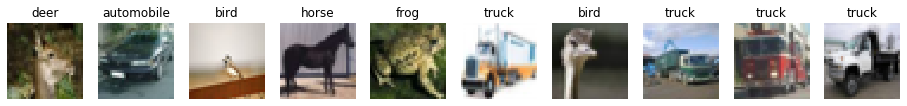

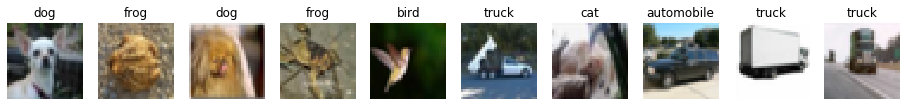

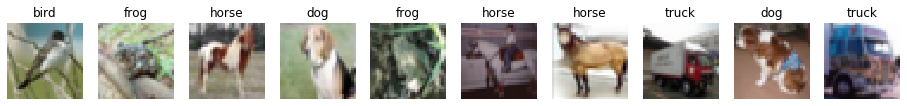

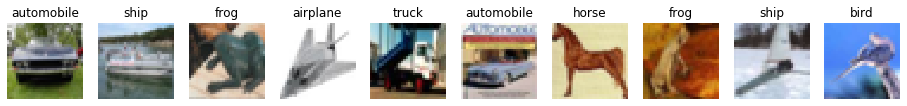

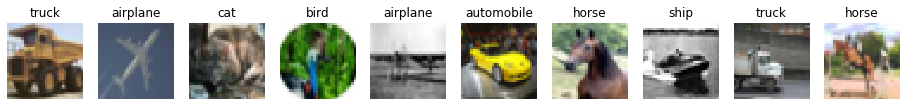

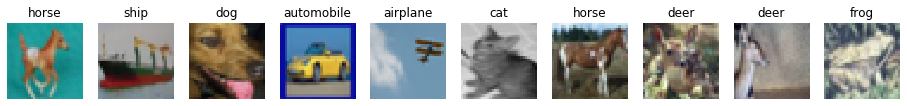

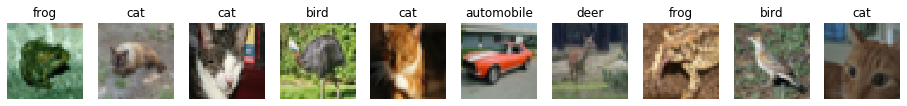

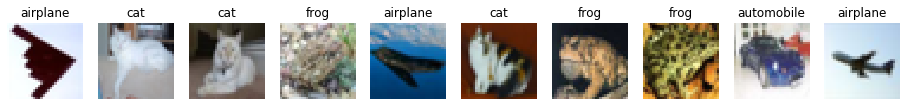

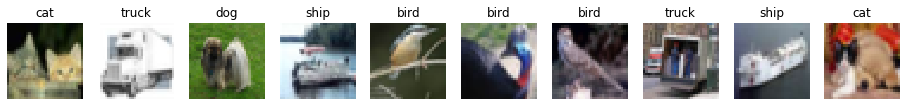

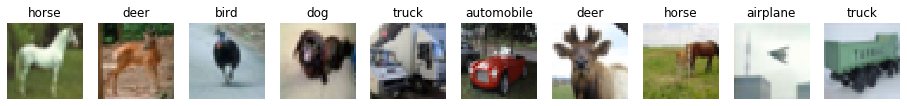

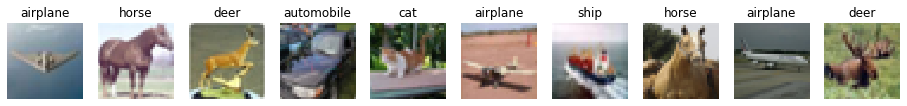

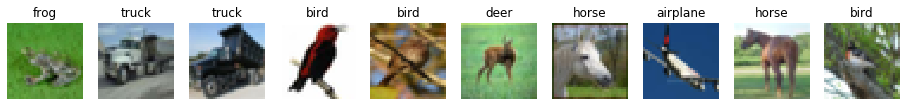

In [143]:
show_panel(cifardata[:10])
show_panel(cifardata[10:20])
show_panel(cifardata[20:30])
show_panel(cifardata[30:40])
show_panel(cifardata[40:50])
show_panel(cifardata[50:60])
show_panel(cifardata[60:70])
show_panel(cifardata[70:80])
show_panel(cifardata[80:90])
show_panel(cifardata[90:100])
show_panel(cifardata[100:110])
show_panel(cifardata[110:120])

In [55]:
good_images = [cifardata[5],cifardata[8],cifardata[11],cifardata[40],cifardata[39],cifardata[23],cifardata[70],cifardata[99]]

In [162]:
list_dict(c10mods)
pgd_attacker.steps = 30


mobilenet_dense
mobilenet_mymethod_pgd26
mobilenet_mymethod_pgd26_1pruned
mobilenet_mymethod_pgd26_5pruned
mobilenet_mymethod_pgd8
mobilenet_mymethod_pgd8_1pruned
mobilenet_mymethod_pgd8_5pruned
mobilenet_pgd_dense
resnet_1pruned_old
resnet_dense1
resnet_mymethod_pgd26
resnet_mymethod_pgd26_1pruned_constloss
resnet_mymethod_pgd26_5pruned
resnet_mymethod_pgd26_5pruned_constloss
resnet_mymethod_pgd8_1pruned
resnet_mymethod_pgd8_5pruned
resnet_mymethod_pgd8_adv
resnet_pgd


In [166]:
# perturbed_display(c10mods['resnet_dense1'],good_images[0][0],good_images[0][1],pgd_attacker,ep_start = ep_s,coeff=c,)
# # perturbed_display(c10mods['resnet_pgd'],tns,lab,pgd_attacker,coeff=2)



10

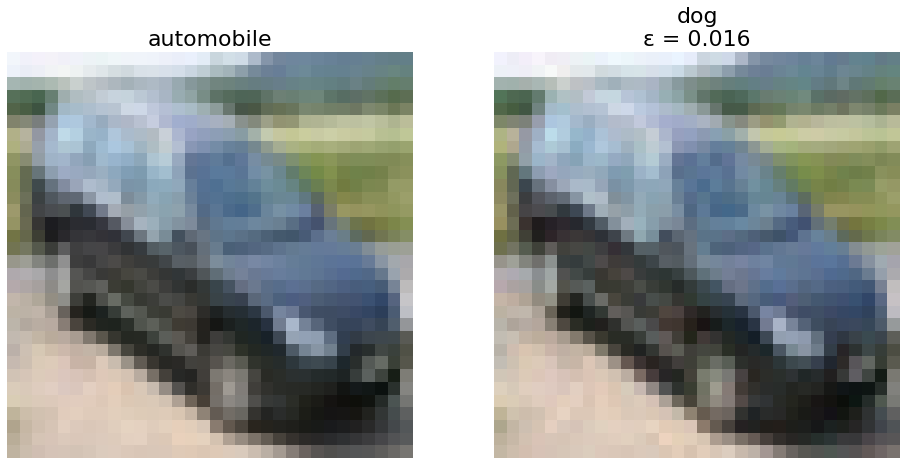

In [83]:
# tns,lab = next(cifar10)
def atk_1img(mod,tns,lab,attacker,eps=8,steps=10):
    labs = CIFAR10_LABELS
    disp = [[tns,lab]]
    attacker.steps = steps
    attacker.epsilon = eps
    atk = attacker.get_attack()
    tns_adv, _ = atk(mod,tns,lab)
    pred = list(mod(tns_adv).data[0])
    pred = pred.index(max(pred))
    tit = "{}\n\u03B5 = {}".format(labs[int(pred)],round(attacker.epsilon/255,3))
    disp.append([tns_adv,pred,tit])
    show_panel(disp)

atk_1img(c10mods['resnet_dense1'],
         tns, lab,
         pgd_attacker,
         eps=4,steps=7)

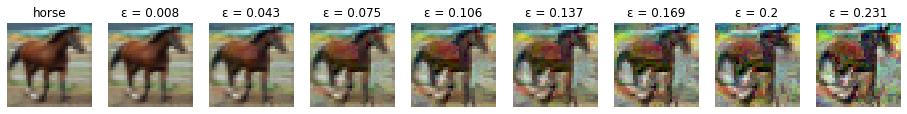

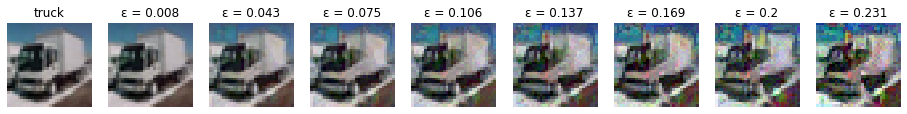

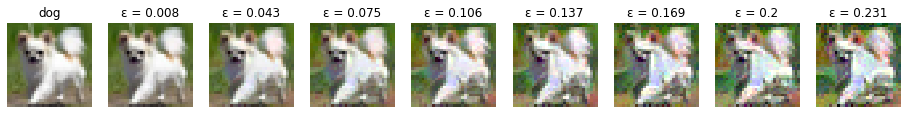

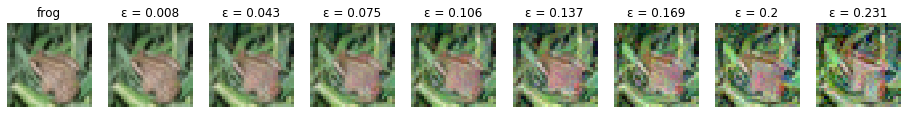

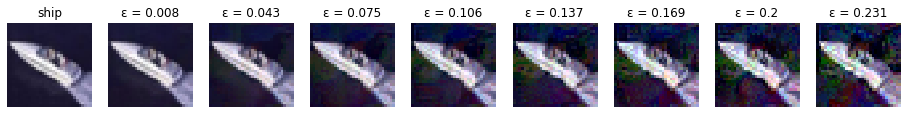

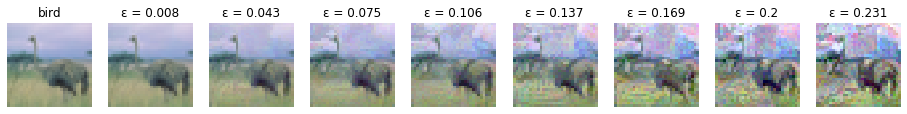

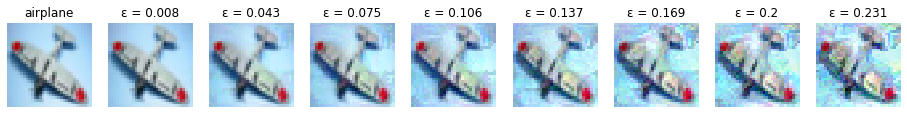

In [151]:
for item in good_images[1:]:
    perturbed_display(c10mods['resnet_pgd'],item[0],item[1],pgd_attacker,ep_start = ep_s,coeff=c,)

### Carlini-Wagner Attack

In [ ]:
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(c10mods['resnet_pgd'].parameters(), lr=0.01)

classifier = PyTorchClassifier(
    loss=criterion,
    optimizer=optimizer,
    model=c10mods['resnet_pgd'],
    input_shape=(3, 32, 32),
    nb_classes=10)

In [ ]:
carlini_L2_attacker = CarliniLInfMethod(classifier)
# dir(carlini_L2_attacker)
carlini_L2_attacker.max_iter = 20
carlini_L2_attacker.eps = 0.003
carlini_L2_attacker.max_iter, carlini_L2_attacker.eps

In [ ]:
for i in range(10):
    tns,lab = next(cifar10)
    x_test_adv = carlini_L2_attacker.generate(x=tns)
    x_adv = torch.tensor(x_test_adv)
    pred = list(c10mods['resnet_pgd'](x_adv ).data[0])
    pred = pred.index(max(pred))

    show_panel([[tns,lab],[torch.tensor(x_adv),pred]])

## The Landscape of Adversarial Attacks
    - Adversarial examples are a particular problem in computer vision. We try to find the perturbations to fool the classifier (untargeted) or to fool the classifier into predicting a given label (targeted)
    - Ideally, none should exist that would still be consistently correctly labeled by a human
    
**Recall Robust ERM (the learning objective)**

> $\min \underset{(x,y)\sim \mathcal{D}}{\mathbb{E}} \: \Big[ \underset{\delta\in\Delta}{\max}\;\; \mathcal{L}_{\theta}\big( x+\delta,y \big) \Big]$

**Now for a twist**

Regarding the **optimal adversarial example $x_{adv}^{*}$** on a deep neural network with parameters $\theta$

> $\forall (x,y) \in \mathcal{D}$

> $x_{adv}^{*} = \underset{\delta\in\Delta}{\arg\min} \; \max \; \mathcal{L}(x+\delta,y\,;\, \theta) \;\;\; $ That is, minimize $||\delta||_{p}\;\;$   ... or whatever metric...

**$x_{adv}^{*}$ is exactly what we want to avoid: it should be hard to find an adversarial example, and those examples should appear to be distorted when evaluated by a human**

### How do we define $\Delta$     ?!?!

**Problems Occur w/**
    - Distance metrics
    - Distortion types
    - The measurement instruments themselves (cameras)
    

<img src="other/espresso_cup.png" width=750>

**Source**: "Testing Robustness Against Unforeseen Adversaries". Kang 2019 (Stanford & OpenAI) https://arxiv.org/pdf/1908.08016.pdf

###  BAD NEWS: In June 2020, $\Delta$ is an *unbounded* set of perturbations

### GOOD NEWS: Research is trending towards more global evaluation standards & open source software

Some good sources about evaluation: 
> [Croce & Stein Auto Attack](https://arxiv.org/pdf/2003.01690.pdf)<br />
> [Carlini & Wagner on Evaluation](https://arxiv.org/pdf/1608.04644.pdf)<br />
> [Carlini & Wagner on Obfuscated Gradients](https://arxiv.org/pdf/1802.00420.pdf)<br />

### I will use the AutoAttack benchmark because it:
    - Provides stronger variants of the white box attack I'm already using (PGD)
    - Has two out of the box attacks I have not implemented myself, one of which is a white box query attack
    - Is relatively easy to hook into programatically

### My Results:
<img src="other/autoAttack_scores.png" width=750>
